In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cafa-6-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-6-protein-function-prediction/IA.tsv
/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta
/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset-taxon-list.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo
/kaggle/input/trained-cafa6-submission/submission_LR_ovr_esm2_650.tsv
/kaggle/input/trained-cafa6-submission/submission_LGBM_top1k.tsv
/kaggle/input/trained-cafa6-submission/submission_LR_ovr_esm2_650_2000.tsv
/kaggle/input/trained-cafa6-submission/submission_gaf.tsv


In [2]:
# ============================================================================
# PACKAGE INSTALLATION
# ============================================================================
# Install any missing packages
!pip install -q obonet biopython
!pip install bio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.9 MB/s eta 0:00:00


## EDA

Installing required packages...
CAFA 6 PROTEIN FUNCTION PREDICTION - ENHANCED STARTER
📊 SAMPLE MODE: 100% of data
⚡ QUICK MODE: ON

[1/9] Loading GO ontology...
   ✓ Loaded 40122 GO terms
   ✓ Ontology breakdown: MF=10131, BP=25950, CC=4041
   Computing GO hierarchy depths...


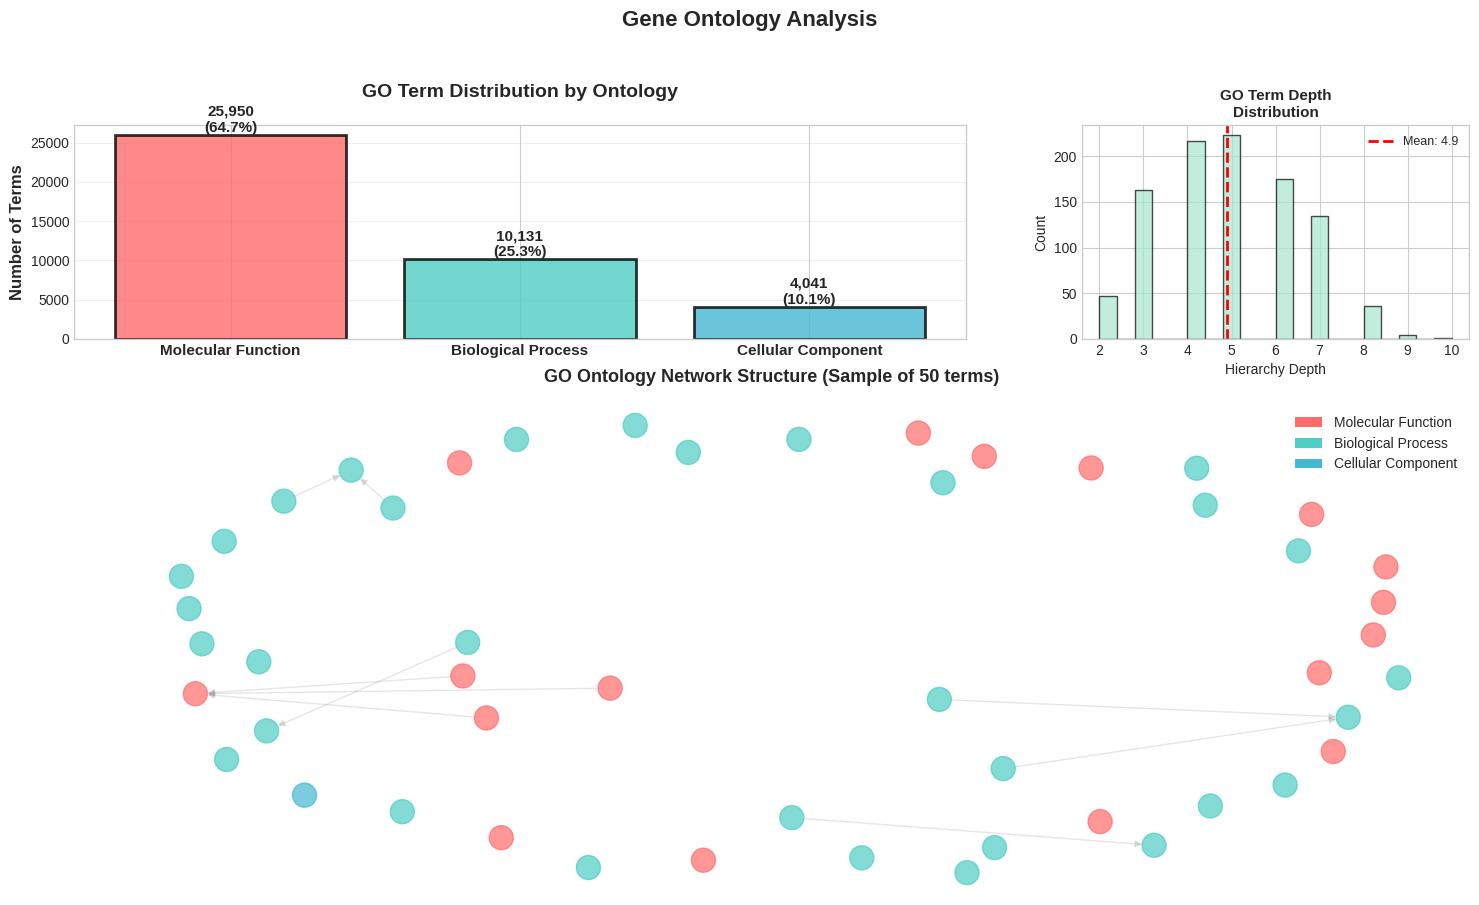


[2/9] Loading IA weights...
   ✓ Loaded 40122 IA weights


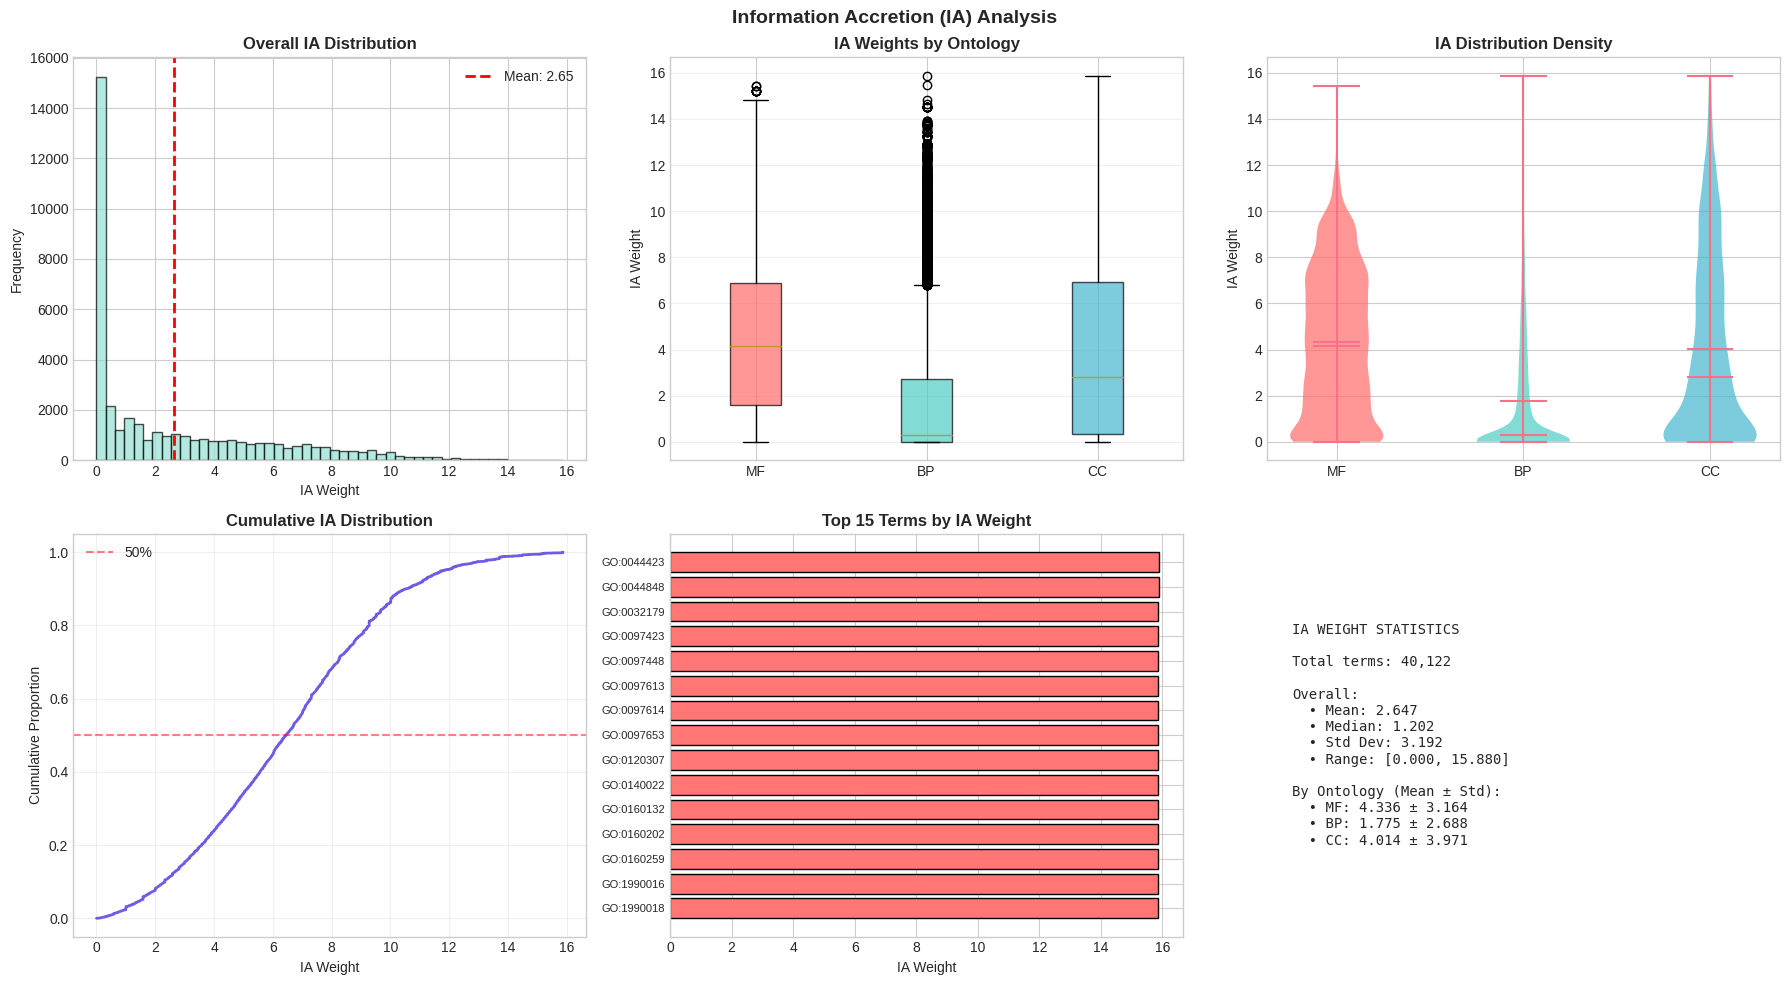


[3/9] Loading training data...
   ✓ Full dataset: 537028 annotations, 82405 proteins

   Ontology distribution:
ontology
P         250805
C         157770
F         128452
aspect         1
Name: count, dtype: int64


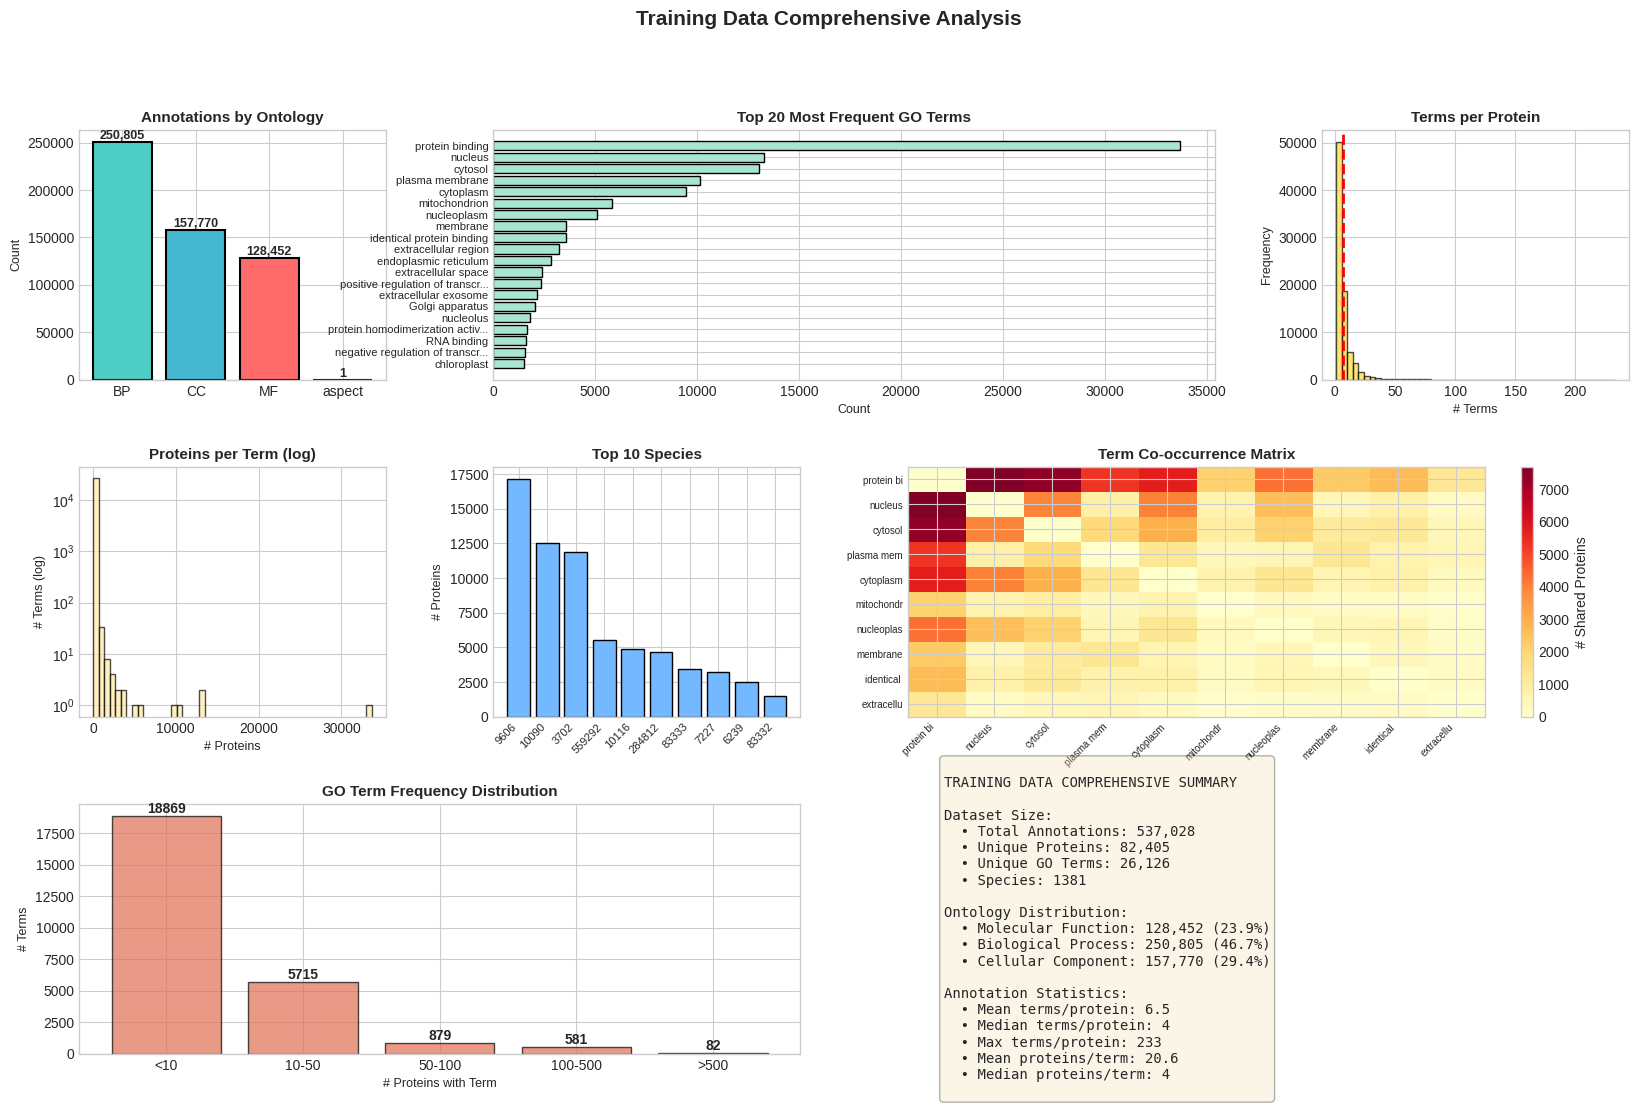


   Loading sequences (this may take a while for 100% of data)...
   Expected proteins: 82,405
      Loaded 10,000 sequences...
      Loaded 20,000 sequences...
      Loaded 30,000 sequences...
      Loaded 40,000 sequences...
      Loaded 50,000 sequences...
      Loaded 60,000 sequences...
      Loaded 70,000 sequences...
      Loaded 80,000 sequences...
   ✓ Loaded 82,404 training sequences
   ✓ Sequence length: mean=526, median=409, range=[3-35213]

✅ Data loading complete! Ready for feature extraction and training.
   Total proteins: 82,404
   Total annotations: 537,028
   Total GO terms: 26,126


In [3]:
# ============================================================================
# CAFA 6 PROTEIN FUNCTION PREDICTION - ENHANCED VERSION (FIXED)
# ============================================================================

# ⚙️ CONFIGURATION - ADJUST THIS FOR SPEED VS ACCURACY
SAMPLE_PERCENT = 100  # Use 100% of data
QUICK_MODE = True   # Enable full feature computation

# Package Installation
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("Installing required packages...")
try:
    import obonet
except:
    install('obonet')
    import obonet

try:
    from Bio import SeqIO
except:
    install('biopython')
    from Bio import SeqIO

# Core Imports
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("CAFA 6 PROTEIN FUNCTION PREDICTION - ENHANCED STARTER")
print(f"📊 SAMPLE MODE: {SAMPLE_PERCENT}% of data")
print(f"⚡ QUICK MODE: {'ON' if QUICK_MODE else 'OFF'}")
print("="*80)

# ============================================================================
# 1. DEFINE PATHS
# ============================================================================
BASE = Path('/kaggle/input/cafa-6-protein-function-prediction')
TRAIN_DIR = BASE / 'Train'
TEST_DIR = BASE / 'Test'

# ============================================================================
# 2. LOAD GO ONTOLOGY (WITH HIERARCHY ANALYSIS)
# ============================================================================
print("\n[1/9] Loading GO ontology...")
go_graph = obonet.read_obo(TRAIN_DIR / 'go-basic.obo')
print(f"   ✓ Loaded {len(go_graph)} GO terms")

# Map terms to ontologies
term_to_ont = {}
term_names = {}
for term_id in go_graph.nodes():
    if 'namespace' in go_graph.nodes[term_id]:
        ns = go_graph.nodes[term_id]['namespace']
        if ns == 'biological_process':
            term_to_ont[term_id] = 'BPO'
        elif ns == 'cellular_component':
            term_to_ont[term_id] = 'CCO'
        elif ns == 'molecular_function':
            term_to_ont[term_id] = 'MFO'
    if 'name' in go_graph.nodes[term_id]:
        term_names[term_id] = go_graph.nodes[term_id]['name']

ont_counts = pd.Series(term_to_ont).value_counts()
print(f"   ✓ Ontology breakdown: MF={ont_counts.get('MFO',0)}, BP={ont_counts.get('BPO',0)}, CC={ont_counts.get('CCO',0)}")

# Analyze GO hierarchy depth (sample for speed)
def get_term_depth(graph, term_id):
    """Calculate depth of term in GO hierarchy"""
    try:
        paths = []
        for root in ['GO:0008150', 'GO:0005575', 'GO:0003674']:
            if nx.has_path(graph, term_id, root):
                paths.append(nx.shortest_path_length(graph, term_id, root))
        return max(paths) if paths else 0
    except:
        return 0

print("   Computing GO hierarchy depths...")
sample_terms_for_depth = list(term_to_ont.keys())[:1000]
term_depths = {term: get_term_depth(go_graph, term) for term in sample_terms_for_depth}

# Visualize ontology with enhanced graphics
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Main ontology distribution
ax1 = fig.add_subplot(gs[0, :2])
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax1.bar(range(len(ont_counts)), ont_counts.values, color=colors, 
               edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_xticks(range(len(ont_counts)))
ax1.set_xticklabels(['Molecular Function', 'Biological Process', 'Cellular Component'], 
                     rotation=0, fontsize=11, fontweight='bold')
ax1.set_title('GO Term Distribution by Ontology', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Number of Terms', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (v, bar) in enumerate(zip(ont_counts.values, bars)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{v:,}\n({v/ont_counts.sum()*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Hierarchy depth distribution
ax2 = fig.add_subplot(gs[0, 2])
depth_values = list(term_depths.values())
ax2.hist(depth_values, bins=20, color='#A8E6CF', edgecolor='black', alpha=0.7)
ax2.set_title('GO Term Depth\nDistribution', fontsize=11, fontweight='bold')
ax2.set_xlabel('Hierarchy Depth', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.axvline(np.mean(depth_values), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(depth_values):.1f}')
ax2.legend(fontsize=9)

# Network visualization (sample of GO graph)
ax3 = fig.add_subplot(gs[1:, :])
sample_terms = list(term_to_ont.keys())[:50]
subgraph = go_graph.subgraph(sample_terms)
pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)
node_colors = [colors[['MFO', 'BPO', 'CCO'].index(term_to_ont.get(node, 'MFO'))] 
               for node in subgraph.nodes()]
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, 
                       node_size=300, alpha=0.7, ax=ax3)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2, arrows=True, 
                       arrowsize=10, ax=ax3, edge_color='gray')
ax3.set_title('GO Ontology Network Structure (Sample of 50 terms)', 
              fontsize=13, fontweight='bold', pad=15)
ax3.axis('off')

# Legend
legend_elements = [mpatches.Patch(facecolor=colors[0], label='Molecular Function'),
                   mpatches.Patch(facecolor=colors[1], label='Biological Process'),
                   mpatches.Patch(facecolor=colors[2], label='Cellular Component')]
ax3.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

plt.suptitle('Gene Ontology Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# 3. LOAD IA WEIGHTS (WITH ANALYSIS)
# ============================================================================
print("\n[2/9] Loading IA weights...")
ia_df = pd.read_csv(BASE / 'IA.tsv', sep='\t', header=None, names=['term', 'ia'])

if SAMPLE_PERCENT < 100:
    ia_df = ia_df.sample(frac=SAMPLE_PERCENT/100, random_state=42)

ia_dict = dict(zip(ia_df['term'], ia_df['ia']))
print(f"   ✓ Loaded {len(ia_dict)} IA weights")

# Enhanced IA visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# IA distribution by ontology
ia_by_ont = ia_df.copy()
ia_by_ont['ontology'] = ia_by_ont['term'].map(term_to_ont)
ia_by_ont = ia_by_ont.dropna()

axes[0, 0].hist(ia_df['ia'], bins=50, color='#95E1D3', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Overall IA Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('IA Weight', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].axvline(ia_df['ia'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {ia_df["ia"].mean():.2f}')
axes[0, 0].legend()

# Box plot by ontology
ont_data = [ia_by_ont[ia_by_ont['ontology']==ont]['ia'].values 
            for ont in ['MFO', 'BPO', 'CCO']]
bp = axes[0, 1].boxplot(ont_data, labels=['MF', 'BP', 'CC'], patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 1].set_title('IA Weights by Ontology', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('IA Weight', fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)

# Violin plot
parts = axes[0, 2].violinplot(ont_data, positions=[1, 2, 3], showmeans=True, showmedians=True)
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
axes[0, 2].set_xticks([1, 2, 3])
axes[0, 2].set_xticklabels(['MF', 'BP', 'CC'])
axes[0, 2].set_title('IA Distribution Density', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('IA Weight', fontsize=10)

# Cumulative distribution
sorted_ia = np.sort(ia_df['ia'].values)
cumsum = np.cumsum(sorted_ia) / np.sum(sorted_ia)
axes[1, 0].plot(sorted_ia, cumsum, linewidth=2, color='#6C5CE7')
axes[1, 0].set_title('Cumulative IA Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('IA Weight', fontsize=10)
axes[1, 0].set_ylabel('Cumulative Proportion', fontsize=10)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50%')
axes[1, 0].legend()

# Top terms by IA
top_ia = ia_df.nlargest(15, 'ia')
axes[1, 1].barh(range(len(top_ia)), top_ia['ia'].values, color='#FF7675', edgecolor='black')
axes[1, 1].set_yticks(range(len(top_ia)))
axes[1, 1].set_yticklabels([f"{t[:15]}..." if len(t) > 15 else t 
                            for t in top_ia['term'].values], fontsize=8)
axes[1, 1].set_title('Top 15 Terms by IA Weight', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('IA Weight', fontsize=10)
axes[1, 1].invert_yaxis()

# Statistics summary
axes[1, 2].axis('off')
ia_stats = f"""
IA WEIGHT STATISTICS

Total terms: {len(ia_df):,}

Overall:
  • Mean: {ia_df['ia'].mean():.3f}
  • Median: {ia_df['ia'].median():.3f}
  • Std Dev: {ia_df['ia'].std():.3f}
  • Range: [{ia_df['ia'].min():.3f}, {ia_df['ia'].max():.3f}]

By Ontology (Mean ± Std):
  • MF: {ia_by_ont[ia_by_ont['ontology']=='MFO']['ia'].mean():.3f} ± {ia_by_ont[ia_by_ont['ontology']=='MFO']['ia'].std():.3f}
  • BP: {ia_by_ont[ia_by_ont['ontology']=='BPO']['ia'].mean():.3f} ± {ia_by_ont[ia_by_ont['ontology']=='BPO']['ia'].std():.3f}
  • CC: {ia_by_ont[ia_by_ont['ontology']=='CCO']['ia'].mean():.3f} ± {ia_by_ont[ia_by_ont['ontology']=='CCO']['ia'].std():.3f}
"""
axes[1, 2].text(0.05, 0.5, ia_stats, fontsize=10, family='monospace',
                verticalalignment='center')

plt.suptitle('Information Accretion (IA) Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# 4. LOAD TRAINING DATA (WITH COMPREHENSIVE ANALYSIS) - FIXED
# ============================================================================
print("\n[3/9] Loading training data...")

train_terms = pd.read_csv(TRAIN_DIR / 'train_terms.tsv', sep='\t', 
                          names=['protein', 'term', 'ontology'])
train_taxonomy = pd.read_csv(TRAIN_DIR / 'train_taxonomy.tsv', sep='\t',
                             names=['protein', 'taxon'])

print(f"   ✓ Full dataset: {len(train_terms)} annotations, {train_terms['protein'].nunique()} proteins")

# SAMPLE proteins for faster iteration
if SAMPLE_PERCENT < 100:
    sample_proteins = train_terms['protein'].drop_duplicates().sample(
        frac=SAMPLE_PERCENT/100, random_state=42
    ).tolist()
    train_terms = train_terms[train_terms['protein'].isin(sample_proteins)]
    train_taxonomy = train_taxonomy[train_taxonomy['protein'].isin(sample_proteins)]
    print(f"   ✓ Sampled to {SAMPLE_PERCENT}%: {len(train_terms)} annotations, {len(sample_proteins)} proteins")

# Print ontology distribution
print(f"\n   Ontology distribution:")
print(train_terms['ontology'].value_counts())

# Comprehensive training data visualization - FIXED
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.35)

# 1. Ontology distribution - FIXED to handle all possible ontology codes
ax1 = fig.add_subplot(gs[0, 0])
ont_dist = train_terms['ontology'].value_counts()

# Map ontology codes (handle F, P, C or any other codes)
colors_ont_map = {'F': '#FF6B6B', 'P': '#4ECDC4', 'C': '#45B7D1'}
ont_names_map = {'F': 'MF', 'P': 'BP', 'C': 'CC'}

# Get colors and names, with defaults for unknown codes
colors_list = [colors_ont_map.get(k, '#CCCCCC') for k in ont_dist.index]
labels_list = [ont_names_map.get(k, k) for k in ont_dist.index]

bars = ax1.bar(range(len(ont_dist)), ont_dist.values, color=colors_list, 
               edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(ont_dist)))
ax1.set_xticklabels(labels_list)
ax1.set_title('Annotations by Ontology', fontsize=11, fontweight='bold')
ax1.set_ylabel('Count', fontsize=9)
for i, (v, bar) in enumerate(zip(ont_dist.values, bars)):
    ax1.text(bar.get_x() + bar.get_width()/2., v, f'{v:,}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Top terms
ax2 = fig.add_subplot(gs[0, 1:3])
top_terms = train_terms['term'].value_counts().head(20)
ax2.barh(range(len(top_terms)), top_terms.values, color='#A8E6CF', edgecolor='black')
ax2.set_yticks(range(len(top_terms)))
ax2.set_yticklabels([f"{term_names.get(t, t)[:30]}..." if len(term_names.get(t, t)) > 30 
                     else term_names.get(t, t) for t in top_terms.index], fontsize=8)
ax2.set_title('Top 20 Most Frequent GO Terms', fontsize=11, fontweight='bold')
ax2.set_xlabel('Count', fontsize=9)
ax2.invert_yaxis()

# 3. Terms per protein
ax3 = fig.add_subplot(gs[0, 3])
terms_per_protein = train_terms.groupby('protein').size()
ax3.hist(terms_per_protein, bins=50, color='#FFD93D', edgecolor='black', alpha=0.7)
ax3.set_title('Terms per Protein', fontsize=11, fontweight='bold')
ax3.set_xlabel('# Terms', fontsize=9)
ax3.set_ylabel('Frequency', fontsize=9)
ax3.axvline(terms_per_protein.mean(), color='red', linestyle='--', linewidth=2)

# 4. Proteins per term
ax4 = fig.add_subplot(gs[1, 0])
proteins_per_term = train_terms.groupby('term').size()
ax4.hist(proteins_per_term, bins=50, color='#FFEAA7', edgecolor='black', alpha=0.7, log=True)
ax4.set_title('Proteins per Term (log)', fontsize=11, fontweight='bold')
ax4.set_xlabel('# Proteins', fontsize=9)
ax4.set_ylabel('# Terms (log)', fontsize=9)

# 5. Taxonomy distribution
ax5 = fig.add_subplot(gs[1, 1])
top_taxa = train_taxonomy['taxon'].value_counts().head(10)
ax5.bar(range(len(top_taxa)), top_taxa.values, color='#74B9FF', edgecolor='black')
ax5.set_xticks(range(len(top_taxa)))
ax5.set_xticklabels([str(t)[:8] for t in top_taxa.index], rotation=45, ha='right', fontsize=8)
ax5.set_title('Top 10 Species', fontsize=11, fontweight='bold')
ax5.set_ylabel('# Proteins', fontsize=9)

# 6. Term co-occurrence heatmap
ax6 = fig.add_subplot(gs[1, 2:])
top_10_terms = train_terms['term'].value_counts().head(10).index
cooc_matrix = np.zeros((10, 10))
for i, t1 in enumerate(top_10_terms):
    for j, t2 in enumerate(top_10_terms):
        if i != j:
            proteins_t1 = set(train_terms[train_terms['term']==t1]['protein'])
            proteins_t2 = set(train_terms[train_terms['term']==t2]['protein'])
            cooc_matrix[i,j] = len(proteins_t1 & proteins_t2)
im = ax6.imshow(cooc_matrix, cmap='YlOrRd', aspect='auto')
ax6.set_xticks(range(10))
ax6.set_yticks(range(10))
ax6.set_xticklabels([term_names.get(t, t)[:10] for t in top_10_terms], 
                     rotation=45, ha='right', fontsize=7)
ax6.set_yticklabels([term_names.get(t, t)[:10] for t in top_10_terms], fontsize=7)
ax6.set_title('Term Co-occurrence Matrix', fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax6, label='# Shared Proteins')

# 7. Annotation density
ax7 = fig.add_subplot(gs[2, :2])
term_freq_bins = pd.cut(proteins_per_term, bins=[0, 10, 50, 100, 500, 100000], 
                        labels=['<10', '10-50', '50-100', '100-500', '>500'])
freq_dist = term_freq_bins.value_counts().sort_index()
ax7.bar(range(len(freq_dist)), freq_dist.values, color='#E17055', edgecolor='black', alpha=0.7)
ax7.set_xticks(range(len(freq_dist)))
ax7.set_xticklabels(freq_dist.index, rotation=0)
ax7.set_title('GO Term Frequency Distribution', fontsize=11, fontweight='bold')
ax7.set_xlabel('# Proteins with Term', fontsize=9)
ax7.set_ylabel('# Terms', fontsize=9)
for i, v in enumerate(freq_dist.values):
    ax7.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# 8. Summary statistics
ax8 = fig.add_subplot(gs[2, 2:])
ax8.axis('off')
summary_text = f"""
TRAINING DATA COMPREHENSIVE SUMMARY

Dataset Size:
  • Total Annotations: {len(train_terms):,}
  • Unique Proteins: {train_terms['protein'].nunique():,}
  • Unique GO Terms: {train_terms['term'].nunique():,}
  • Species: {train_taxonomy['taxon'].nunique()}

Ontology Distribution:
  • Molecular Function: {ont_dist.get('F', 0):,} ({ont_dist.get('F', 0)/len(train_terms)*100:.1f}%)
  • Biological Process: {ont_dist.get('P', 0):,} ({ont_dist.get('P', 0)/len(train_terms)*100:.1f}%)
  • Cellular Component: {ont_dist.get('C', 0):,} ({ont_dist.get('C', 0)/len(train_terms)*100:.1f}%)

Annotation Statistics:
  • Mean terms/protein: {terms_per_protein.mean():.1f}
  • Median terms/protein: {terms_per_protein.median():.0f}
  • Max terms/protein: {terms_per_protein.max()}
  • Mean proteins/term: {proteins_per_term.mean():.1f}
  • Median proteins/term: {proteins_per_term.median():.0f}
"""
ax8.text(0.05, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Training Data Comprehensive Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Continue with the rest of the code (sequences, features, training, etc.)
print("\n   Loading sequences (this may take a while for 100% of data)...")
print(f"   Expected proteins: {train_terms['protein'].nunique():,}")

train_seqs = {}
loaded_count = 0
target_proteins = set(train_terms['protein'].unique())

for rec in SeqIO.parse(TRAIN_DIR / 'train_sequences.fasta', 'fasta'):
    pid = rec.id.split('|')[1] if '|' in rec.id else rec.id
    if pid in target_proteins:
        train_seqs[pid] = str(rec.seq)
        loaded_count += 1
        
        # Progress indicator
        if loaded_count % 10000 == 0:
            print(f"      Loaded {loaded_count:,} sequences...")
        
    if loaded_count >= len(target_proteins):
        break

print(f"   ✓ Loaded {len(train_seqs):,} training sequences")

# Enhanced sequence analysis
seq_lengths = [len(s) for s in train_seqs.values()]
print(f"   ✓ Sequence length: mean={np.mean(seq_lengths):.0f}, "
      f"median={np.median(seq_lengths):.0f}, range=[{min(seq_lengths)}-{max(seq_lengths)}]")

print("\n✅ Data loading complete! Ready for feature extraction and training.")
print(f"   Total proteins: {len(train_seqs):,}")
print(f"   Total annotations: {len(train_terms):,}")
print(f"   Total GO terms: {train_terms['term'].nunique():,}")

## Ensemble from 2 trained model: 
Logistic regression - One vs Rest 

LightGBM - top 1k GO labels

In [4]:
import pandas as pd

lgbm_df = pd.read_csv("/kaggle/input/trained-cafa6-submission/submission_LGBM_top1k.tsv", sep="\t")
lr_df = pd.read_csv("/kaggle/input/trained-cafa6-submission/submission_LR_ovr_esm2_650.tsv", sep="\t")

lr_df.columns = ["protein_id", "go_term", "pred_lr"]
lgbm_df.columns = ["protein_id", "go_term", "pred_lgbm"]

merged = pd.merge(
    lr_df,
    lgbm_df,
    on=["protein_id", "go_term"],
    how="outer"
)

prob_lgbm = 0
prob_lr = 1

def ensemble(row):
    if pd.notna(row["pred_lgbm"]) and pd.notna(row["pred_lr"]):
        return prob_lgbm * row["pred_lgbm"] + prob_lr * row["pred_lr"]
    elif pd.notna(row["pred_lgbm"]):
        return row["pred_lgbm"]
    else:
        return row["pred_lr"]


merged["prediction"] = merged.apply(ensemble, axis=1)

final_df = merged[["protein_id", "go_term", "prediction"]]

final_df = final_df.sort_values(by=['protein_id', 'prediction'], ascending=[True, False])
final_df = final_df.groupby('protein_id').head(2000).reset_index(drop=True)

print("LR predictions:", len(lr_df))
print("LGBM predictions:", len(lgbm_df))
print("Ensembled predictions:", len(final_df))

print("Overlap count:",
      ((merged["pred_lr"].notna()) & (merged["pred_lgbm"].notna())).sum())
# 4. Merging dataframe
# Remove 0 scores and scores > 1
submission = final_df[final_df['prediction'] >= 0.06]
submission.loc[:, 'prediction'] = submission['prediction'].clip(upper=1.0)
submission = submission.groupby('protein_id').head(1500).reset_index(drop=True)
submission.to_csv(
    "lgbm_ensemble.tsv",
    sep="\t",
    index=False,
    header=True
)


LR predictions: 5430179
LGBM predictions: 4537322
Ensembled predictions: 7677843
Overlap count: 2289658


In [5]:
import pandas as pd

gaf_df = pd.read_csv("/kaggle/input/trained-cafa6-submission/submission_gaf.tsv", sep="\t")
lr_df = pd.read_csv("/kaggle/input/trained-cafa6-submission/submission_LR_ovr_esm2_650.tsv", sep="\t")

lr_df.columns = ["protein_id", "go_term", "pred_lr"]
gaf_df.columns = ["protein_id", "go_term", "pred_gaf"]

merged = pd.merge(
    lr_df,
    gaf_df,
    on=["protein_id", "go_term"],
    how="outer"
)

prob_gaf = 0.5
prob_lr = 0.5

def ensemble(row):
    if pd.notna(row["pred_gaf"]) and pd.notna(row["pred_lr"]):
        return prob_gaf * row["pred_gaf"] + prob_lr * row["pred_lr"]
    elif pd.notna(row["pred_gaf"]):
        return row["pred_gaf"]
    else:
        return row["pred_lr"]


merged["prediction"] = merged.apply(ensemble, axis=1)

final_df = merged[["protein_id", "go_term", "prediction"]]

final_df = final_df.sort_values(by=['protein_id', 'prediction'], ascending=[True, False])


print("LR predictions:", len(lr_df))
print("GAF predictions:", len(gaf_df))
print("Ensembled predictions:", len(final_df))

print("LR nan: ", (merged["pred_lr"].isna()).sum())
print("GAF nan: ", (merged["pred_gaf"].isna()).sum())

print("Overlap count:",
      ((merged["pred_lr"].notna()) & (merged["pred_gaf"].notna())).sum())

# 4. Merging dataframe
# Remove 0 scores and scores > 1
submission = final_df[final_df['prediction'] >= 0.06]
submission.loc[:, 'prediction'] = submission['prediction'].clip(upper=1.0)
submission = submission.groupby('protein_id').head(1500).reset_index(drop=True)
submission.to_csv(
    "submission.tsv",
    sep="\t",
    index=False,
    header=True
)
submission.shape

LR predictions: 5430179
GAF predictions: 7677843
Ensembled predictions: 7677843
LR nan:  2247664
GAF nan:  0
Overlap count: 5430179


(3626205, 3)